# PREDICTIVE MAINTENANCE

# I. Data Preparation
__Source Dataset__ : [archive.ics.uci.edu](https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset#) 

Dataset is a synthetic dataset that reflects real predictive maintenance encountered in industry. There are total 10000 rows and 14 features. Information of each feature will be explained in table below :

| Col Num | Feature Name | Feature Description |
|--------|:-----------:|:--------------------|
|1|  **UID** |Unique identifier ranging.|
|2|  **Product ID** | A variant-specific serial number.|
|3| **Type**| Product quality variants (L : Low, M : Medium, H : High).|
|4| **Air Temperature [K]** |Generated using a random walk process later normalized to a standard deviation of 2 K around 300 K.|
|5| **Process Temperature [K]**| Generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.|
|6| **Rotational Speed [rpm]**| : Calculated from a power of 2860 W, overlaid with a normally distributed noise.|
|7| **Torque [Nm]**| Torque values are normally distributed around 40 Nm with a Ïƒ = 10 Nm and no negative values.|
|8| **Tool Wear [min]:**|  The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.|
|9| **Machine Failure**| Label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true.|
|10| **Tool Wear Failure (TWF)**| The tool will be replaced of fail at a randomly selected tool wear time between 200 â€“ 240 mins.|
|11| **Heat Dissipation Failure (HDF)**|  Heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the toolâ€™s rotational speed is below 1380 rpm.|
|12| **Power Failure (PWF):**| The product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails. |
|13| **Overstrain Failure (OSF)**| : If the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain.|
|14| **Random Failures (RNF)**| : Each process has a chance of 0,1 % to fail regardless of its process parameters. |

In [1]:
# Import all libraries needed
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pingouin as pg
from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV

from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier

from sklearn.metrics import classification_report, auc, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, plot_roc_curve, precision_recall_curve, plot_precision_recall_curve, confusion_matrix, plot_confusion_matrix

C:\Users\Iki\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
C:\Users\Iki\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.3.12.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
df = pd.read_csv('ai4i2020.csv')
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [4]:
df.shape

(10000, 14)

In [5]:
df.isna().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

Based on data preparation steps above, the datates is clean from any missing values. Then, the data types on each features are also quite right. I will try to show the summary of the dataset below.

In [6]:
def summary(df):
    dtype = []
    nan = []
    nan_perc = []
    nunique = []
    unique = []
    
    for i in df.columns:
        dtype.append(df[i].dtype)
        nan.append(df[i].isna().sum())
        nan_perc.append((df[i].isna().sum()/len(df[i]))*100)
        nunique.append(df[i].nunique())
        val_counts = df[i].value_counts(normalize=True)
        unique.append(list(val_counts.index))
    
    summary_df = pd.DataFrame({'dtype': dtype, 'nan' : nan, 'nan_perc' : nan_perc, 'nunique' : nunique, 'unique': unique}, index=df.columns)
    
    return display(summary_df)

In [7]:
summary(df)

,dtype,nan,nan_perc,nunique,unique
UDI,int64,0,0.0,10000,"[2049, 8865, 6806, 4759, 8857, 2716, 669, 6814..."
Product ID,object,0,0.0,10000,"[M22547, H34770, L54116, L56199, L52466, L5641..."
Type,object,0,0.0,3,"[L, M, H]"
Air temperature [K],float64,0,0.0,93,"[300.7, 298.9, 297.4, 300.5, 298.8, 300.6, 298..."
Process temperature [K],float64,0,0.0,82,"[310.6, 310.8, 310.7, 308.6, 310.5, 310.1, 308..."
Rotational speed [rpm],int64,0,0.0,941,"[1452, 1435, 1447, 1469, 1479, 1429, 1418, 145..."
Torque [Nm],float64,0,0.0,577,"[40.2, 42.4, 35.8, 38.5, 37.7, 38.2, 39.9, 40...."
Tool wear [min],int64,0,0.0,246,"[0, 2, 5, 59, 7, 166, 119, 9, 146, 96, 148, 18..."
Machine failure,int64,0,0.0,2,"[0, 1]"
TWF,int64,0,0.0,2,"[0, 1]"


Based on the summary, we can know about the dataset more detail, for example number of unique value and its value. 
- __`UDI`__ and __`Product ID`__ features will be deleted soon because these only give the identity of data and every rows/data are different value. These do not determine the probability of machine failure.
- Independent failure modes (__`TWF`, `HDF`, `PWF`, `OSF`, `RNF`__) features will be deleted for modeling because these will leak information for the model later. But for now, I will use it just for looking some insights.

# II. Exploratory Data Analysis (EDA)
## A. Target Feature

In [8]:
df['Machine failure'].value_counts(normalize=True)

0    0.9661
1    0.0339
Name: Machine failure, dtype: float64

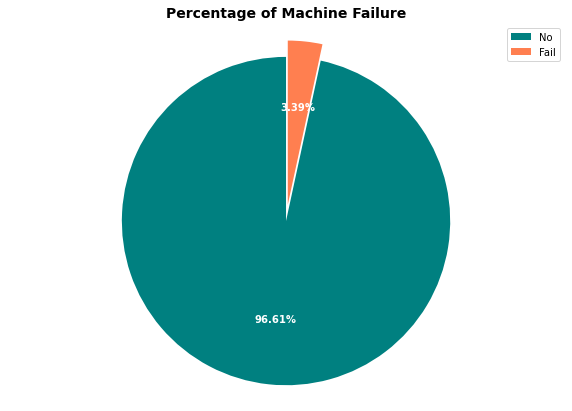

In [9]:
plt.figure(figsize=(10,7))
plt.title('Percentage of Machine Failure', fontweight='bold', fontsize=14)
plt.pie(df['Machine failure'].value_counts(), 
        colors = ['teal', 'coral'],
        autopct='%.2f%%',
        textprops = {'color' : 'white', 'weight' : 'bold'},
        explode = [0,0.1],
        startangle = 90)
plt.legend(['No', 'Fail'], loc='upper right')
plt.axis('equal')
plt.show()

Based on Percentage of Machine Failure on Pie Chart above, we cann see that the target feature is Imbalance Data. If the dataset is real it means it is goof for the company. Because the machine failure is measly. But, it is not good for model later because the model is not sensitive to predict fail compared to not fail. To hadle it, I will try to apply resampling method to get the data more balance.

## B. Satatistical Analysis

Statistical analysis was performed on numerical data. This analysis is carried out to investigate the characteristics of the data through several statistical methods.

 > ## 1. Descriptive Statistics

In [10]:
# select all numerical continous features
num_cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
df[num_cols].head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,298.1,308.6,1551,42.8,0
1,298.2,308.7,1408,46.3,3
2,298.1,308.5,1498,49.4,5
3,298.2,308.6,1433,39.5,7
4,298.2,308.7,1408,40.0,9


In [11]:
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Air temperature [K],10000.0,300.00493,2.000259,295.3,298.3,300.1,301.5,304.5
Process temperature [K],10000.0,310.00556,1.483734,305.7,308.8,310.1,311.1,313.8
Rotational speed [rpm],10000.0,1538.77610,179.284096,1168.0,1423.0,1503.0,1612.0,2886.0
Torque [Nm],10000.0,39.98691,9.968934,3.8,33.2,40.1,46.8,76.6
Tool wear [min],10000.0,107.95100,63.654147,0.0,53.0,108.0,162.0,253.0


The `.describe` above is the summary of descriptive statistics on the numerical dataset. It contains information about mean, standard deviation, minimum values, maximum values as well as the quantiles. For example, on __`Air Temperature`__, We can see that it has mean of 300.00493 and standard deviation of 2.000259 (let's round it up to 300 and 2). From these information we can say that __the average air temperature of machine in this dataset are on 300 K with variety between 298 K (300-2) and 302 K (300+2)__.

> ## 2. Normality Test

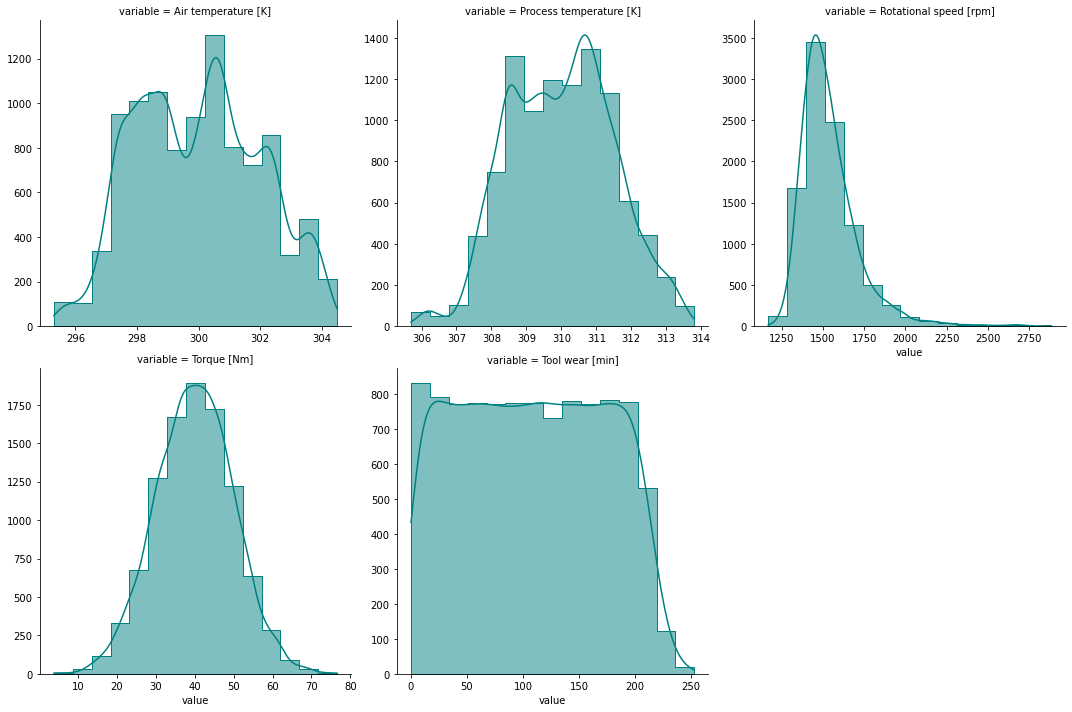

In [12]:
num_dist = sns.FacetGrid(df[num_cols].melt(), col='variable', sharex=False, sharey=False, height=5, col_wrap=3)
num_dist.map(sns.histplot, 'value', kde=True, element='step', bins=15, color='teal')
plt.show()

In [13]:
NumericalFeature = []
t_stat = []
p_value = []
APT = []

for col in num_cols :
    NumericalFeature.append(col)

    alpha = 0.05
        
    # Agostino-Pearson Test
    tstat, p = stats.normaltest(df[col], nan_policy='omit')
    t_stat.append(tstat)
    p_value.append(p)
    if p < alpha:
        APT.append('Non Normal Distribution')
    else :
        APT.append('Normal Distribution')

normality_df = pd.DataFrame({
    'Feature' : NumericalFeature,
    'T-Stat' : t_stat,
    'P-Value' : p_value,
    'Agostino-Pearson Test Result' : APT
    })

display(normality_df)
print('Alpha = 5%')

,Feature,T-Stat,P-Value,Agostino-Pearson Test Result
0,Air temperature [K],1026.938504,1.007250e-223,Non Normal Distribution
1,Process temperature [K],191.267738,2.929129e-42,Non Normal Distribution
2,Rotational speed [rpm],4395.347069,0.000000e+00,Non Normal Distribution
3,Torque [Nm],0.212607,8.991517e-01,Normal Distribution
4,Tool wear [min],6560.525754,0.000000e+00,Non Normal Distribution


Alpha = 5%


Normality Test can be analized from the distribution of data on __Histogram and Agostino-Pearson Test__. For Agostino-Pearson, alpha used is 0.05. If the P-Value score of every feature is higher than alpha, we can assume that the feature is normally distributed. If not, the feature is not normally distributed. Based on the result on table, normally distributed data is only for __`Torque`__ and the others are not normally normally distributed.

> ## 3. Ouliers Detection

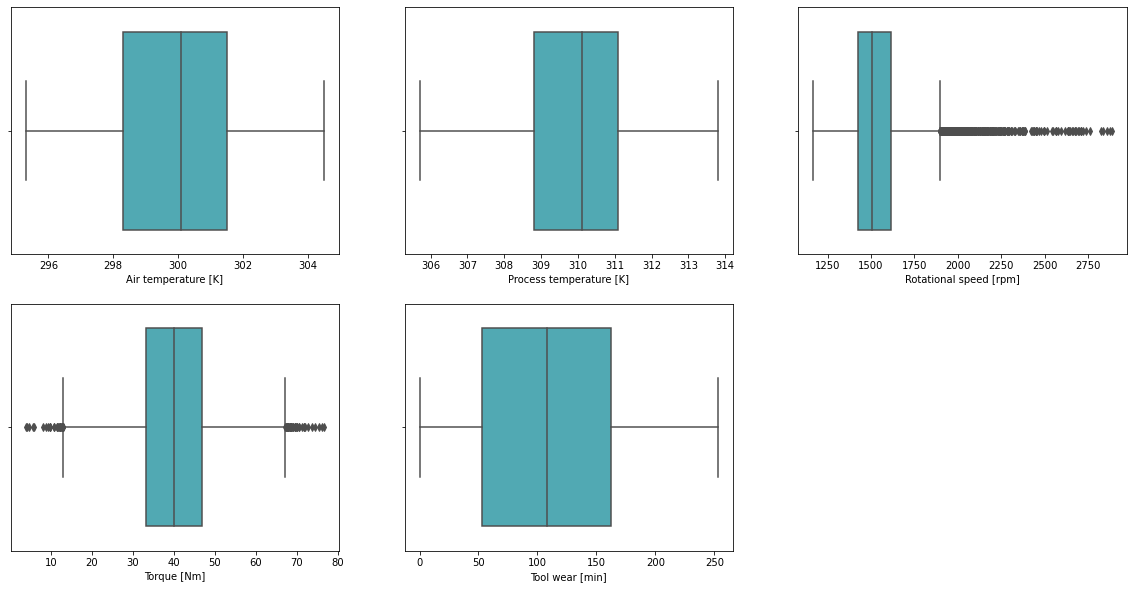

In [14]:
fig, ax = plt.subplots(2,2, figsize=(20,10))
ax = ax.flatten()

for i, col in enumerate(num_cols) :
    plt.subplot(2, 3, i+1)
    sns.boxplot(data=df, x=col, palette='YlGnBu')
plt.show()

In [15]:
df[num_cols].skew()

Air temperature [K]        0.114274
Process temperature [K]    0.015027
Rotational speed [rpm]     1.993171
Torque [Nm]               -0.009517
Tool wear [min]            0.027292
dtype: float64

Outliers can hurt our models performance. But, not all outliers mean wrong data. So that, We should analyze it. Ouliers can be detected from boxplot. Also, Skewed distribution is one of the characteristics that a feature has outliers. Based on boxplot, the features that have outliers are __`Rotational Speed` and `Torque`__. But, we know that the __`Torque`__ feature is normal distribution data. So that, I am not worried about this feature. I will focus on __`Rotational Speed`__ feature, where this feature has skewness level more than 1. Let's analyze data that are distributed more than 99,7 percentile on __`Rotational Speed`__ feature.

In [16]:
# check outliers data
outlier_df = df[df['Rotational speed [rpm]'] > np.nanpercentile(df['Rotational speed [rpm]'], 99.7)]
outlier_df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
50,51,L47230,L,298.9,309.1,2861,4.6,143,1,0,0,1,0,0
194,195,M15054,M,298.2,308.5,2678,10.7,86,1,0,0,1,0,0
380,381,L47560,L,297.5,308.3,2564,12.8,127,1,0,0,1,0,0
463,464,L47643,L,297.4,308.7,2874,4.2,118,1,0,0,1,0,0
847,848,L48027,L,296.4,307.4,2833,5.6,213,1,0,0,1,0,0
1095,1096,L48275,L,296.9,307.5,2721,9.3,18,1,0,0,1,0,0
1391,1392,L48571,L,298.9,310.2,2737,8.8,142,1,0,0,1,0,0
1784,1785,L48964,L,298.3,308.0,2886,3.8,57,1,0,0,1,0,0
1808,1809,L48988,L,298.1,307.7,2567,12.8,125,1,0,0,1,0,0
2233,2234,L49413,L,299.5,308.7,2549,13.0,179,1,0,0,1,0,0


In [17]:
outlier_df['Machine failure'].value_counts(normalize=True)*100

1    86.666667
0    13.333333
Name: Machine failure, dtype: float64

We can see from the percetage above that machine failure has many outliers value. We can assume that the outliers are anomaly data causing machine feature. So, I will keep it and try to analyze it more detail.

## C. Numeric Features Analysis

> ## 1. Correlation Between Numeric Independent Features - Dependent Features

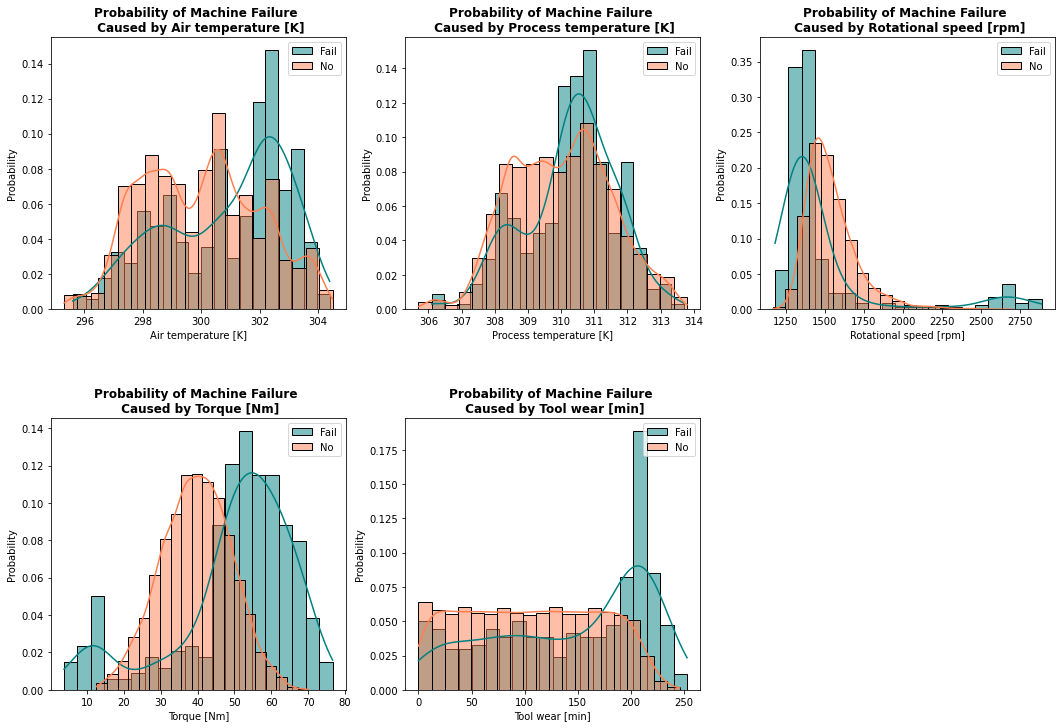

In [18]:
a = 2  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(18, 12))
fig.subplots_adjust(hspace=0.4, wspace=0.2)

for col in df[num_cols].columns :
    plt.subplot(a, b, c)
    plt.title('Probability of Machine Failure \n Caused by {}'.format(col), fontweight="bold")
    sns.histplot(df[df['Machine failure'] == 1][col], stat='probability', label='Fail', color='teal', kde=True, bins=20)
    sns.histplot(df[df['Machine failure'] == 0][col], stat='probability', label='No', color='coral', kde=True, bins=20)
    plt.legend(loc='upper right')
    c = c + 1

plt.show()

Based on probability of every numeric independent feature to dependent feature (__`Failure Machine`__), we can get some insights :
- __`Air Temperature`__ : Higher air temperature can cause the probability of machine failure higher. Many machine failure occur when the air temperature more than 302 K.
- __`Process Temperature`__ : High process temperature, range 310 until 312, can cause the pobability of machine failure higher.
- __`Rotational Speed`__ : The slower speed or the faster speed can cause the probability of machine failure higher. It confirms us to do not delete the high value analized as outliers before. Normal rotational speed of machine is range from 1500 rpm until 2250 rpm.
- __`Torque`__: The lower torque or the higher torque can cause the probability of machine failure higher. Normal torque of machine is range from 20 Nm until 45 Nm.
- __`Tool wear`__ : Longer tool wear can cause the probability of machine failure higher. Many machine failure occur when the tool wear more than 200 minutes.


Based on the data below, We can avoid the machine failure if We operate the machine with following standard paramater as shown below. Do not force the machine to work exceed its specification. If We see something wrong from those features, We should maintain the machine.

> ## 2. Correlation Between Numeric Independent Features - Numeric Independent Features

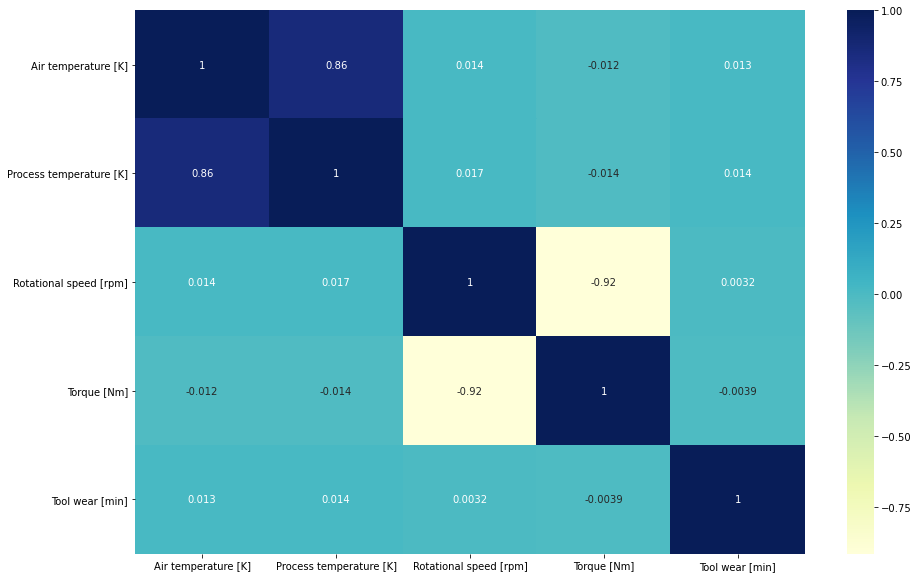

In [19]:
plt.figure(figsize=(15,10))
sns.heatmap(df[num_cols].corr('spearman'), annot=True, cmap='YlGnBu')
plt.show()

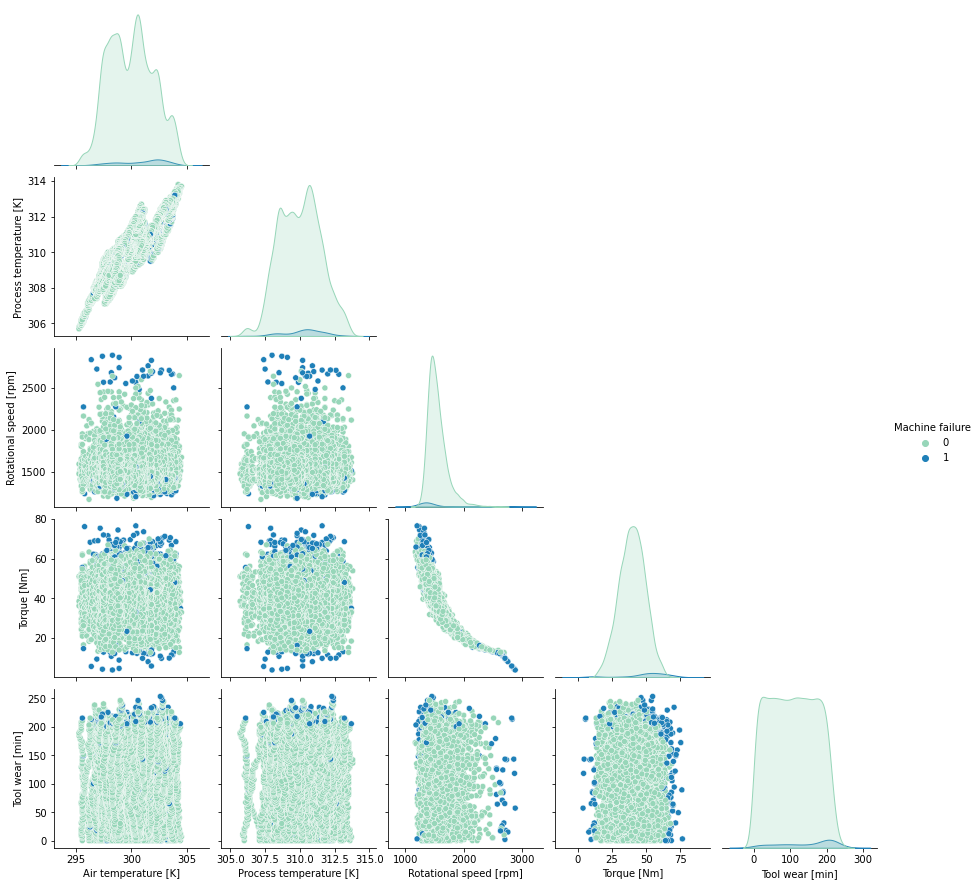

In [20]:
g = sns.pairplot(df[list(num_cols) + ['Machine failure']], 
                 hue = 'Machine failure',
                 corner = True,
                 palette='YlGnBu')
plt.show()

To know correlation between two features We can alyze from correlation plot and pair plot. Based on these plot, We can see that there are high correlation between __`Process Temperature` - `Air Temperature`__ and between __`Torque` - `Rotational Speed`__. 
- The correlation between __`Process Temperature` - `Air Temperature`__ is positive. It means the higher process temperature the higher air temperature.
- The correlation between __`Torque` - `Rotational Speed`__ is negative. It means the higher rotational speed but the lower torque.

## D. Category Features Analysis

> ## 1. Correlation Between Category Independent Features - Dependent Features

In [21]:
# filter data for category types only
cat_cols = ['Type', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
cat_df = df[cat_cols].copy()
cat_df.head()

,Type,Machine failure,TWF,HDF,PWF,OSF,RNF
0,M,0,0,0,0,0,0
1,L,0,0,0,0,0,0
2,L,0,0,0,0,0,0
3,L,0,0,0,0,0,0
4,L,0,0,0,0,0,0


In [22]:
cat_df['Type'].value_counts()

L    6000
M    2997
H    1003
Name: Type, dtype: int64

In [23]:
# rename value for easier analysis
for col in cat_df.columns :
    if col == 'Type' :
        cat_df[col] = cat_df[col].replace({'L' : 'Low', 'M' : 'Medium', 'H' : 'High'})
    else :
        cat_df[col] = cat_df[col].replace({0 : 'No', 1 : 'Fail'})

In [24]:
cat_df.head()

,Type,Machine failure,TWF,HDF,PWF,OSF,RNF
0,Medium,No,No,No,No,No,No
1,Low,No,No,No,No,No,No
2,Low,No,No,No,No,No,No
3,Low,No,No,No,No,No,No
4,Low,No,No,No,No,No,No


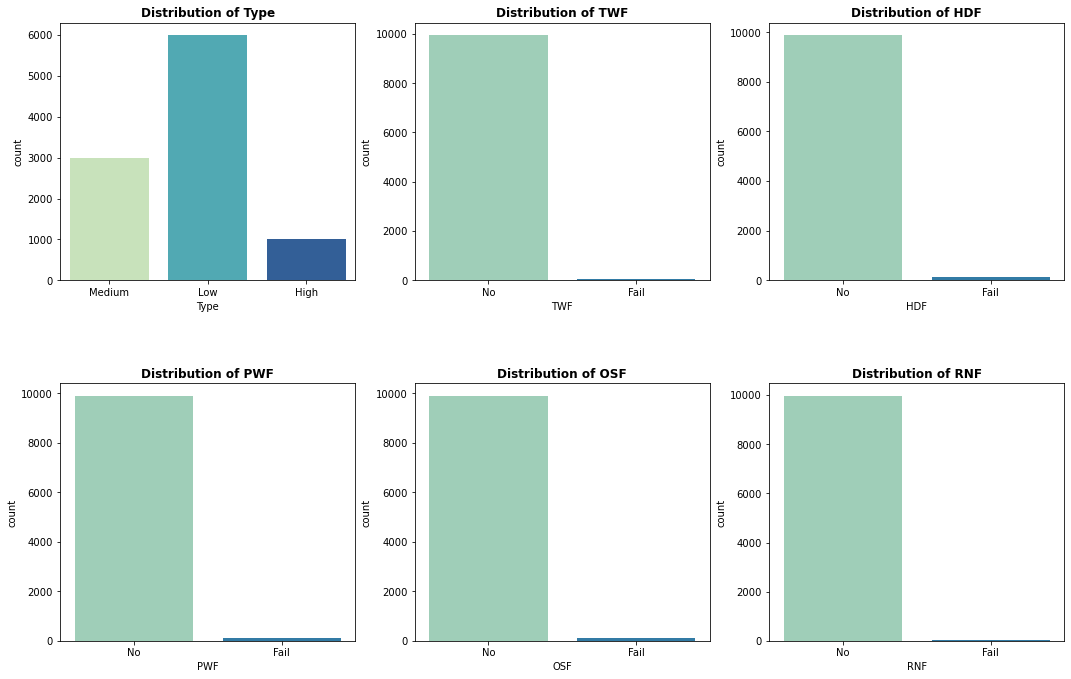

In [25]:
a = 3  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(18, 18))
fig.subplots_adjust(hspace=0.4, wspace=0.2)

for col in cat_df.drop('Machine failure', axis=1).columns :
    plt.subplot(a, b, c)
    plt.title('Distribution of {}'.format(col), fontweight="bold")
    sns.countplot(x=col, data=cat_df, palette='YlGnBu')
#     plt.legend(loc='upper right')
    c = c + 1

plt.show()

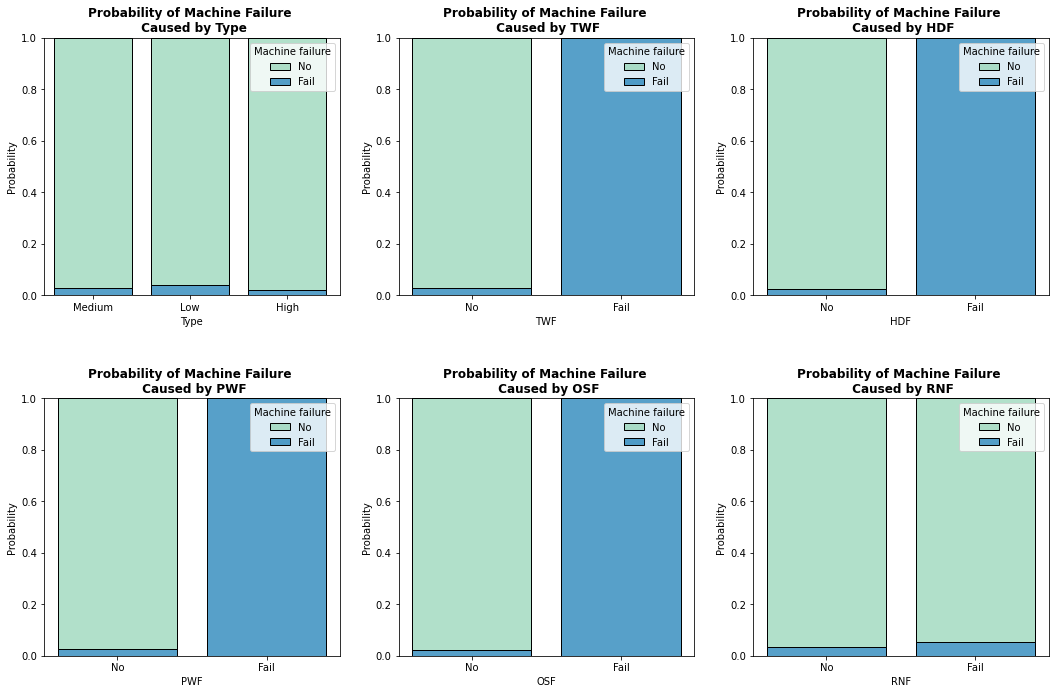

In [26]:
a = 3  # number of rows
b = 3  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(18, 18))
fig.subplots_adjust(hspace=0.4, wspace=0.2)

for col in cat_df.drop('Machine failure', axis=1).columns :
    plt.subplot(a, b, c)
    plt.title('Probability of Machine Failure \n Caused by {}'.format(col), fontweight="bold")
    sns.histplot(data=cat_df, x=col, hue='Machine failure', stat="probability", multiple="fill", shrink=.8, palette='YlGnBu')
    c = c + 1

# plt.savefig('Categorical Plot.jpg')
plt.show()

Based on probability of every category independent feature to dependent feature (__`Failure Machine`__), we can get some insights :
- __`Type`__ : Type of machine does not really effect to machine failure because there are no significant gap between one to another. However, if we sort by type, the low type one has propbility of machine failure than the others following medium type, and high type. 
- Failure Modes (__`TWF`, `HDF`, `PWF`, `OSF`, `RNF`__) : As mentioned before, these features contain leak information of machine failure. All failures from __`TWF`, `HDF`, `PWF`, `OSF`__ modes can cause machine failure, except __`RNF`__ mode. It is not really effect to machine failure.

In [27]:
# caout data of failure machine caused by failure mode
df_mode = df.groupby('Machine failure').sum().reset_index()
df_mode = df_mode[df_mode['Machine failure'] == 1][['TWF', 'HDF', 'PWF', 'OSF', 'RNF']].T.reset_index()
df_mode.columns = ['Mode', 'Number']
df_mode.sort_values('Number', ascending=False)

,Mode,Number
1,HDF,115
3,OSF,98
2,PWF,95
0,TWF,46
4,RNF,1


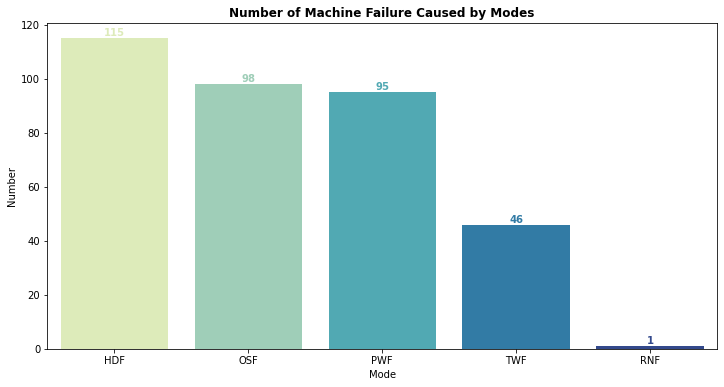

In [28]:
plt.figure(figsize=(12, 6))
g = sns.barplot(x='Mode', y='Number', data=df_mode.sort_values('Number', ascending=False), ci=None, palette='YlGnBu')
for idx, p in enumerate(g.patches) :
    g.text(x=idx, y=p.get_height()+2, s=int(p.get_height()),
           ha='center', va='center', 
           fontweight='bold', color=p.get_fc())
plt.title('Number of Machine Failure Caused by Modes', fontweight="bold")
plt.show()

Based of bar chart below, we can see that most of machince failure are caused by failure on __`HDW`__ mode with 115 failures followed by __`OSF, PWF, TWF`__ and only 1 machine failure caused by __`RNF`__ from the dataset..

# III. Modeling
At modeling process, I will try to apply 3 different machine learning alghorithms from classification method, Logistic Regresssion, K-Nearest Neighbor, and Random Forest. Steps to choose the best model for those algorithms can be explained below :
1. Compare the best score from benchmark model with hyperparameter tuned model from every algorithms
2. Compare the best score of those 3 algorithms resulted from step 1.

The modeling process is done end-to-end using Pipeline. In the Pipeline, there are pre-processing steps, namely standard scaler for transform numeric feature to get best result of KNN and one-hot encoding to transform category features. Do not forget to apply resampling method using Smote. After those pre-processig steps, the data will be trained for predicting.

## Evaluation Metric

In the classification case, We should aware form this 2 type errors, False Positif (FP) and False Negatif (FN). If defined at predictive maintenance, we can assume :
- __FP__ = There are machines might be predicted failure, but actual is good condition.
- __FN__ = There are machines might be good condition, but actual is failure.

Based on those type errors, We expect the model could decrease the number of False Negative (FN). The company try to avoid machine failure earlier. Beacuse if the company is wrong when predicting can cause greater loss, production might stop, and would be dangerous for employee if the are operating the machines. So that, We can focus on Reacll score, where the higher Recall score result better model. 

## A. Feature Selection

In [29]:
def summary(df):
    dtype = []
    nan = []
    nan_perc = []
    nunique = []
    unique = []
    
    for i in df.columns:
        dtype.append(df[i].dtype)
        nan.append(df[i].isna().sum())
        nan_perc.append((df[i].isna().sum()/len(df[i]))*100)
        nunique.append(df[i].nunique())
        val_counts = df[i].value_counts(normalize=True)
        unique.append(list(val_counts.index))
    
    summary_df = pd.DataFrame({'dtype': dtype, 'nan' : nan, 'nan_perc' : nan_perc, 'nunique' : nunique, 'unique': unique}, index=df.columns)
    
    return display(summary_df)

In [30]:
summary(df)

,dtype,nan,nan_perc,nunique,unique
UDI,int64,0,0.0,10000,"[2049, 8865, 6806, 4759, 8857, 2716, 669, 6814..."
Product ID,object,0,0.0,10000,"[M22547, H34770, L54116, L56199, L52466, L5641..."
Type,object,0,0.0,3,"[L, M, H]"
Air temperature [K],float64,0,0.0,93,"[300.7, 298.9, 297.4, 300.5, 298.8, 300.6, 298..."
Process temperature [K],float64,0,0.0,82,"[310.6, 310.8, 310.7, 308.6, 310.5, 310.1, 308..."
Rotational speed [rpm],int64,0,0.0,941,"[1452, 1435, 1447, 1469, 1479, 1429, 1418, 145..."
Torque [Nm],float64,0,0.0,577,"[40.2, 42.4, 35.8, 38.5, 37.7, 38.2, 39.9, 40...."
Tool wear [min],int64,0,0.0,246,"[0, 2, 5, 59, 7, 166, 119, 9, 146, 96, 148, 18..."
Machine failure,int64,0,0.0,2,"[0, 1]"
TWF,int64,0,0.0,2,"[0, 1]"


In [31]:
df.columns

Index(['UDI', 'Product ID', 'Type', 'Air temperature [K]',
       'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]',
       'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF',
       'RNF'],
      dtype='object')

In [32]:
df.drop(['UDI', 'Product ID', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1, inplace=True)
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
0,M,298.1,308.6,1551,42.8,0,0
1,L,298.2,308.7,1408,46.3,3,0
2,L,298.1,308.5,1498,49.4,5,0
3,L,298.2,308.6,1433,39.5,7,0
4,L,298.2,308.7,1408,40.0,9,0


As mentioned before __`UDI`, `Product ID`, `TWF`, `HDF`, `PWF`, `OSF`, `RNF`__ features are deleted because there is no impact and leak informationn.

## B. Data Splitting

In [33]:
X = df.drop('Machine failure', axis=1)
y = df['Machine failure']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=2021)

In [35]:
for i in X_train, X_test, y_train, y_test :
    print(i.shape)

(8000, 6)
(2000, 6)
(8000,)
(2000,)


The proportion of data training is 80% and data testing is 20%. The composition can be seen below.

## C. Logistic Regression Performance

> ## 1. Logistic Regresion Pipeline

In [36]:
onehot_pipe = Pipeline([
    ('onehot', OneHotEncoder())
])

logreg_preprocessor = ColumnTransformer([
    ('onehot', onehot_pipe, ['Type']),
], remainder='passthrough')

logreg_pipe = Pipeline([
    ('transformer', logreg_preprocessor),
    ('resampling', SMOTE(random_state=2021)),
    ('logreg', LogisticRegression(random_state=2021))
])

> ## 2. Cross Validation Score of Logistic Regression

In [37]:
skfold = StratifiedKFold(n_splits=5, random_state=2021, shuffle=True)
logreg_score = cross_val_score(logreg_pipe, X_train, y_train, scoring='recall', cv=skfold, n_jobs=-1)
logreg_score

array([0.81481481, 0.83333333, 0.7962963 , 0.7962963 , 0.89090909])

In [38]:
def cross_val_result(model_score, model_name) :
    plt.figure(figsize=(8,5))
    plt.plot(np.arange(1,6,1), model_score, marker='o', color='teal', 
             label=f'Recall (mean = {round(abs(model_score.mean()), 2)})')
    plt.title('Cross Validation Score of {}'.format(model_name), fontweight='bold')
    plt.xlabel('Fold')
    plt.ylabel('Score')
    plt.xticks(np.arange(1,6,1))
    plt.ylim([0, 1])
    plt.legend()
    plt.show()

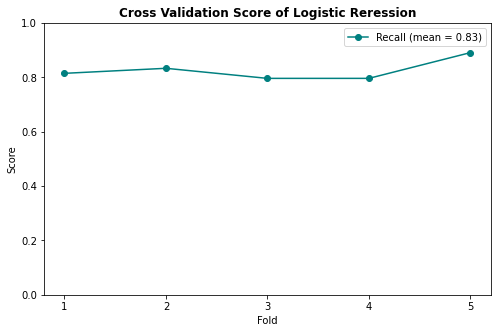

In [39]:
cross_val_result(logreg_score, 'Logistic Reression')

Based on cross validation result of logistic regression below, we can see that the training data give good performance and stable in every fold with mean of Recall score 0.83

> ## 3. Benchmark Model Test Score of Logistic Regression

In [40]:
logreg_default = logreg_pipe.fit(X_train, y_train)
logreg_pred = logreg_default.predict(X_test) 

In [41]:
print('Report for Logistic Regression Benchmark : \n')
print(classification_report(y_test, logreg_pred))

Report for Logistic Regression Benchmark : 

              precision    recall  f1-score   support

           0       0.99      0.82      0.90      1932
           1       0.14      0.81      0.23        68

    accuracy                           0.82      2000
   macro avg       0.56      0.81      0.57      2000
weighted avg       0.96      0.82      0.88      2000



There is no big different Recall score when the model performs with data training (0.83) and performs with data testing (0.81). It means that the model does not indicate overfitting or underfitting.

> ## 4. Hyperparameter Tuning Model Test Score of Logistic Regression

In [42]:
logreg_params = {
    'logreg__C': np.arange(0,15,2),
    'logreg__solver': ['lbfgs', 'liblinear', 'newton-cg'],
    'logreg__penalty' : ['l1', 'l2', 'elasticnet']
}

grid_logreg = GridSearchCV(
    logreg_pipe, 
    param_grid = logreg_params, # hyperparameter option
    cv = skfold, # evaluation method
    scoring = 'recall', # metrics
    n_jobs = -1,
    verbose = 1
)

grid_logreg.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


C:\Users\Iki\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan 0.74518519        nan
 0.82632997 0.82632997 0.81905724        nan        nan        nan
        nan 0.73784512        nan 0.82632997 0.82632997 0.81905724
        nan        nan        nan        nan 0.73784512        nan
 0.82632997 0.82632997 0.81905724        nan        nan        nan
        nan 0.73784512        nan 0.82632997 0.82632997 0.82276094
        nan        nan        nan        nan 0.74154882        nan
 0.82632997 0.82632997 0.81905724        nan        nan        nan
        nan 0.74154882        nan 0.82632997 0.82632997 0.82276094
        nan        nan        nan        nan 0.74154882        nan
 0.82632997 0.82632997 0.81905724        nan        nan        nan]
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2021, shuffle=True),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder())]),
                                                                         ['Type'])])),
                                       ('resampling', SMOTE(random_state=2021)),
                                       ('logreg',
                                        LogisticRegression(random_state=2021))]),
             n_jobs=-1,
             param_grid={'logreg__C': array([ 0,  2,  4,  6,  8, 10, 12, 14]),
                         'logreg__penalty': ['l1', 'l2', 'elasticnet'],
                

In [43]:
# get best parameters of Logistic Regression
grid_logreg.best_params_

{'logreg__C': 2, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}

In [44]:
logreg_tuned = grid_logreg.best_estimator_.fit(X_train, y_train)
logreg_pred_tuned = logreg_tuned.predict(X_test)

In [45]:
print('Report for Logistic Regression Hyperparameter Tuning : \n')
print(classification_report(y_test, logreg_pred_tuned))

Report for Logistic Regression Hyperparameter Tuning : 

              precision    recall  f1-score   support

           0       0.99      0.82      0.90      1932
           1       0.14      0.81      0.23        68

    accuracy                           0.82      2000
   macro avg       0.56      0.81      0.57      2000
weighted avg       0.96      0.82      0.88      2000



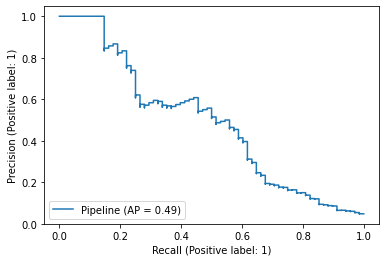

In [46]:
plot_precision_recall_curve(logreg_tuned, X_test, y_test)
plt.show()

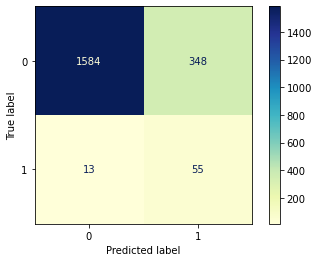

In [47]:
plot_confusion_matrix(logreg_tuned, X_test, y_test, cmap='YlGnBu')
plt.show()

Recall score resulted from hyperparameter tuning model has similar score with bechmark model. It means that the default parameters are the best parameter for Logistic Regression.

## D. K-Nearest Neighbor Performance

> ## 1. K-Nearest Neighbor Pipeline

In [49]:
onehot_pipe = Pipeline([
    ('onehot', OneHotEncoder())
])

numscaled_pipe = Pipeline([
    ('scaling', StandardScaler())
])

knn_preprocessor = ColumnTransformer([
    ('onehot', onehot_pipe, ['Type']),
    ('scaling', numscaled_pipe, ['Air temperature [K]', 'Process temperature [K]', 
                                 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]'])
], remainder='passthrough')

knn_pipe = Pipeline([
    ('transformer', knn_preprocessor),
    ('resampling', SMOTE(random_state=2021)),
    ('knn', KNeighborsClassifier())
])

> ## 2. Cross Validation Score of K-Nearest Neighbor

In [50]:
skfold = StratifiedKFold(n_splits=5, random_state=2021, shuffle=True)
knn_score = cross_val_score(knn_pipe, X_train, y_train, scoring='recall', cv=skfold, n_jobs=-1)
knn_score

array([0.7037037 , 0.7037037 , 0.77777778, 0.75925926, 0.76363636])

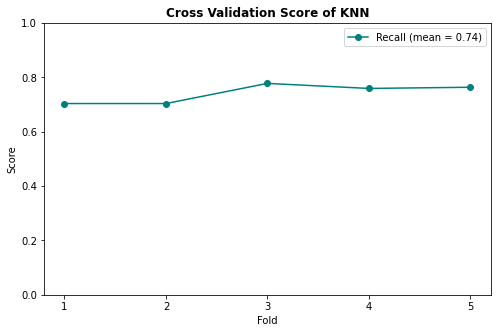

In [51]:
cross_val_result(knn_score, 'KNN')

Based on cross validation result of K-Nearest Neighbor below, we can see that the training data give good performance and stable in every fold with mean of Recall score 0.74

> ## 3. Benchmark Model Test Score of K-Nearest Neighbor

In [52]:
knn_default = knn_pipe.fit(X_train, y_train)
knn_pred = knn_default.predict(X_test) 

In [53]:
print('Report for K-Nearest Neighbor Benchmark : \n')
print(classification_report(y_test, knn_pred))

Report for K-Nearest Neighbor Benchmark : 

              precision    recall  f1-score   support

           0       0.99      0.94      0.97      1932
           1       0.32      0.79      0.46        68

    accuracy                           0.94      2000
   macro avg       0.66      0.87      0.71      2000
weighted avg       0.97      0.94      0.95      2000



There is no big different Recall score when the model performs with data training (0.74) and performs with data testing (0.79). It means that the model does not indicate overfitting or underfitting.

> ## 4. Hyperparameter Tuning Model Test Score of K-Nearest Neighbor

In [54]:
knn_params = {
        'knn__n_neighbors': np.arange(3,22,2),
        'knn__weights' : ['uniform', 'distance'],
        'knn__metric' : ['euclidean', 'minkowski', 'manhattan'],
        'knn__leaf_size': np.arange(10,110,10)
}


grid_knn = GridSearchCV(
    knn_pipe, 
    param_grid = knn_params, # hyperparameter option
    cv = skfold, # evaluation method
    scoring = 'recall', # metrics
    n_jobs = -1,
    verbose = 1
)

grid_knn.fit(X_train, y_train)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2021, shuffle=True),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder())]),
                                                                         ['Type']),
                                                                        ('scaling',
                                                                         Pipeline(steps=[('scaling',
                                                                                          StandardScaler())]),
                                                                         ['Air '
                              

In [55]:
# get best parameters of K-Nearest Neighbor
grid_knn.best_params_

{'knn__leaf_size': 10,
 'knn__metric': 'euclidean',
 'knn__n_neighbors': 21,
 'knn__weights': 'uniform'}

In [56]:
knn_tuned = grid_knn.best_estimator_.fit(X_train, y_train)
knn_pred_tuned = knn_tuned.predict(X_test)

In [57]:
print('Report for K-Nearest Neighbor Hyperparameter Tuning : \n')
print(classification_report(y_test, knn_pred_tuned))

Report for K-Nearest Neighbor Hyperparameter Tuning : 

              precision    recall  f1-score   support

           0       0.99      0.89      0.94      1932
           1       0.22      0.85      0.35        68

    accuracy                           0.89      2000
   macro avg       0.61      0.87      0.64      2000
weighted avg       0.97      0.89      0.92      2000



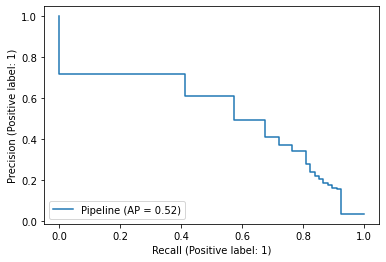

In [58]:
plot_precision_recall_curve(knn_tuned, X_test, y_test)
plt.show()

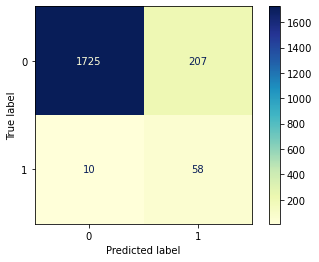

In [59]:
plot_confusion_matrix(knn_tuned, X_test, y_test, cmap='YlGnBu')
plt.show()

Recall resulted from hyperparameter tuning model (0.85) is higher than bechmark model (0.74).

## E. Random Forest Performance

> ## 1. Random Forest Pipeline

In [60]:
onehot_pipe = Pipeline([
    ('onehot', OneHotEncoder())
])

rfc_preprocessor = ColumnTransformer([
    ('onehot', onehot_pipe, ['Type']),
], remainder='passthrough')

rfc_pipe = Pipeline([
    ('transformer', rfc_preprocessor),
    ('resampling', SMOTE(random_state=2021)),
    ('rfc', RandomForestClassifier(random_state=2021))
])

> ## 2. Cross Validation Score of Random Forest

In [61]:
rfc_score = cross_val_score(rfc_pipe, X_train, y_train, scoring='recall', cv=skfold, n_jobs=-1)
rfc_score

array([0.57407407, 0.59259259, 0.61111111, 0.72222222, 0.6       ])

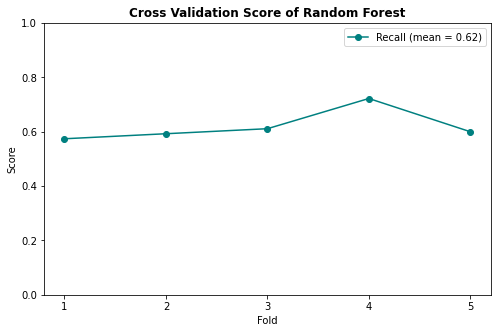

In [62]:
cross_val_result(rfc_score, 'Random Forest')

Based on cross validation result of logistic regression below, we can see that on Random Forest the raining data do not give good enough performance if copared to others. However, it is stable in every fold with mean of Recall score 0.62.

> ## 4. Benchmark Model Test Score of Random Forest

In [63]:
rfc_default = rfc_pipe.fit(X_train, y_train)
rfc_pred = rfc_default.predict(X_test) 

In [64]:
print('Report for Random Forest Benchmark : \n')
print(classification_report(y_test, rfc_pred))

Report for Random Forest Benchmark : 

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1932
           1       0.53      0.69      0.60        68

    accuracy                           0.97      2000
   macro avg       0.76      0.83      0.79      2000
weighted avg       0.97      0.97      0.97      2000



There is no big different Recall score when the model performs with data training (0.62) and performs with data testing (0.69). It means that the model does not indicate overfitting or underfitting.

> ## 4. Hyperparameter Tuning Model Test Score of Random Forest

In [65]:
rfc_params = {
    'rfc__max_depth': np.arange(6, 16, 2),
    'rfc__min_samples_split': [2, 5, 10],
    'rfc__min_samples_leaf': [1, 2, 5],
    'rfc__n_estimators': [100, 500, 1000]
}

skfold = StratifiedKFold(n_splits = 5, random_state=77, shuffle=True)

grid_rfc = GridSearchCV(
    rfc_pipe, 
    param_grid = rfc_params, # hyperparameter option
    cv = skfold, # evaluation method
    scoring = 'recall', # metrics
    n_jobs = -1,
    verbose = 1
)
 
grid_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 135 candidates, totalling 675 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=77, shuffle=True),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder())]),
                                                                         ['Type'])])),
                                       ('resampling', SMOTE(random_state=2021)),
                                       ('rfc',
                                        RandomForestClassifier(random_state=2021))]),
             n_jobs=-1,
             param_grid={'rfc__max_depth': array([ 6,  8, 10, 12, 14]),
                         'rfc__min_samples_leaf': [1, 2, 5],
                         'rfc__min_

In [66]:
# get best parameters of Random Forest
grid_rfc.best_params_

{'rfc__max_depth': 6,
 'rfc__min_samples_leaf': 1,
 'rfc__min_samples_split': 2,
 'rfc__n_estimators': 100}

In [67]:
rfc_tuned = grid_rfc.best_estimator_.fit(X_train, y_train)
rfc_pred_tuned = rfc_tuned.predict(X_test)

In [68]:
print('Report for Random Forest Hyperparameter Tuning : \n')
print(classification_report(y_test, rfc_pred_tuned))

Report for Random Forest Hyperparameter Tuning : 

              precision    recall  f1-score   support

           0       0.99      0.92      0.95      1932
           1       0.25      0.74      0.37        68

    accuracy                           0.92      2000
   macro avg       0.62      0.83      0.66      2000
weighted avg       0.96      0.92      0.93      2000



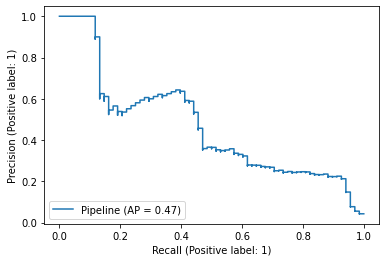

In [69]:
plot_precision_recall_curve(rfc_tuned, X_test, y_test)
plt.show()

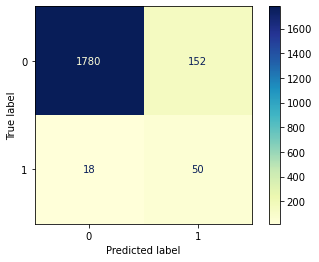

In [70]:
plot_confusion_matrix(rfc_tuned, X_test, y_test, cmap='YlGnBu')
plt.show()

Recall resulted from hyperparameter tuning model (0.74) is higher than bechmark model (0.69).

## F. Model Comparison

In [71]:
summary_model = pd.DataFrame()
summary_model['Models'] = ['Logistic Regresion']*2 + ['K-Nearest Neighbor']*2 + ['Random Forest']*2
summary_model['Variations'] = ['Benchmark', 'Tuned']*3
model_score = []
for i in [logreg_pred, logreg_pred_tuned, knn_pred, knn_pred_tuned, rfc_pred, rfc_pred_tuned] :
    model_score.append(recall_score(y_test, i))
summary_model['Recall_Scores'] = model_score
summary_model = summary_model.pivot(index='Variations', columns='Models', values='Recall_Scores')

In [72]:
summary_model[summary_model.columns].style.background_gradient('YlGnBu')

Models,K-Nearest Neighbor,Logistic Regresion,Random Forest
Variations,,,
Benchmark,0.794118,0.808824,0.691176
Tuned,0.852941,0.808824,0.735294


By looking at the Recall score table above, all of alorithms applied with hyperparameter tuning give better performance. It means that hyperparameter tuning process is important step to improve our model performance. However, we still choose one model used for predictive maintenance. Based on the all Recall scores resulted from 3 different algorithms, the K-Nearest Neighbor has the highest recall score (0.86) than others.

## G. Feature Importance

In [73]:
X_train_pre = rfc_preprocessor.fit_transform(X_train)

In [74]:
X_train_pre = pd.DataFrame(X_train_pre)
features = list(rfc_preprocessor.transformers_[0][1]['onehot'].get_feature_names()) + list(X_train.columns[1::])
X_train_pre.columns = features

In [75]:
X_train_pre.head()

,x0_H,x0_L,x0_M,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
0,0.0,0.0,1.0,297.2,308.5,1487.0,46.9,173.0
1,1.0,0.0,0.0,298.6,309.4,1362.0,45.3,56.0
2,0.0,1.0,0.0,300.1,311.5,1549.0,34.7,189.0
3,0.0,1.0,0.0,301.4,310.7,1436.0,54.1,90.0
4,0.0,1.0,0.0,298.1,308.7,1556.0,31.6,145.0


[0.00350714 0.00547946 0.00432927 0.15300819 0.13048868 0.22220516
 0.29399185 0.18699026]


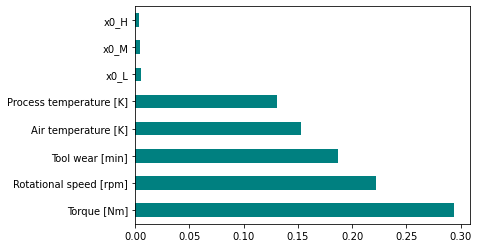

In [76]:
# feature importances using Tree Based Classifier
model = ExtraTreesClassifier()
model.fit(X_train_pre, y_train)
print(model.feature_importances_)

# plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_train_pre.columns)
feat_importances.nlargest(8).plot(kind = 'barh', color='teal')
plt.show()

Based on bar chart below, we can see that __`Torque`__ is most importance feature of machine failure followed by __`Rotational speed`, `Tool wear`, `Air temperature`__, and the last is __`Type`__. The feature importance extracted from Tree Based Classifier is similar with our Exploratory Data Analysis, where the __`Type`__ doet not give big impact for machine failure.

# IV. Conclusion

After aalyzing the dataset and creating model, can be concluded :  
1. The are several factors causing machine failure. The company shoud be aware if the machine perform with :
    - High air temperature
    - High proces temperature
    - Very slow rotational speed or very fast rotational speed
    - Very low torque or very high torque
    - Long tool wear


2. For predictive maintenance, K-Nearest Neighbor algorithm performs better than the others and it can fit for this case with Recall score 0.86.